In [1]:
#Python/Data
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import numpy as np
import h5py as h5
import uproot3 as ur
import awkward as ak

from matplotlib import style
#style.use('/global/home/users/ftoralesacosta/dotfiles/scientific.mplstyle')

import os
import shutil

#ML
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split
import tensorflow as tf

## File Names and Output Directory

In [2]:
#filename = "2M_uncompressed.hdf5"
h5_filename = "../generate_data/to_hdf5/Ecut_GeV.hdf5"
ROOT_file = "../generate_data/to_hdf5/2M_piplus.root"

label = "MAE_Cut_genTheta_Cluster_AND_genP"  #Replace with your own variation!      
path = "./"+label

shutil.rmtree(path, ignore_errors=True)
os.makedirs(path)

## Data Cuts

In [3]:
N_Events = 100_000

cut_on_clusters = True
cut_on_genTheta = True
cut_on_genP = False #True for Debug only

min_theta = 5.0 #5 for HCAL
max_theta = 30.0

hit_e_max = 1e10 #Spikes...
hit_e_min = 0.00006 #MIPs
hit_t_max = 200

min_cluster_E = 0.2 #GeV
#min_cluster_E = 0.0 #GeV

## Model Settings

In [4]:
learning_rate = 1e-5
dropout_rate = 0.05
batch_size = 1000
N_Epochs = 400
patience = 20
N_Latent = 128
shuffle_split = True #Turn FALSE for images!
train_shuffle = False #False for better root hf comparison
Y_scalar = True
loss = 'mae'

## I/O

In [5]:
h5_file = h5.File(h5_filename,'r')
print(list(h5_file.keys()))

ur_file = ur.open( ROOT_file )
ur_tree = ur_file['events']

['hcal', 'mc']


#### Get HDF5 E hits and Gen P

In [6]:
h5_detector = 'hcal'
h5_gen_P = h5_file['mc'][:N_Events,8,0]
h5_gen_Theta = h5_file['mc'][:N_Events,9,0]
h5_hits_e = h5_file[h5_detector][:N_Events,0]

#### Get ROOT E hits and Gen P

In [7]:
root_detector = "HcalEndcapPHitsReco"

genPx = ur_tree.array('MCParticles.momentum.x',entrystop=N_Events)[:,2]
genPy = ur_tree.array('MCParticles.momentum.y',entrystop=N_Events)[:,2]
genPz = ur_tree.array('MCParticles.momentum.z',entrystop=N_Events)[:,2]
root_gen_P = np.sqrt(genPx*genPx + genPy*genPy + genPz*genPz)
root_gen_Theta = np.arccos(genPz/root_gen_P)*180/np.pi

root_hits_e = ur_tree.array('%s.energy' % root_detector, entrystop=N_Events)
root_hits_t = ur_tree.array('%s.time' % root_detector, entrystop=N_Events)

ROOT needs to have cuts applied here. HDF5 File should already have them applied

In [8]:
root_cuts = root_hits_e > hit_e_min                                                                   
root_cuts = np.logical_and( root_cuts, root_hits_e <= hit_e_max )                                     
root_cuts = np.logical_and( root_cuts, root_hits_t <= hit_t_max )  

root_hits_e = root_hits_e[root_cuts]

/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/awkward0/array/base.py:622: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif isinstance(where, (cls.numpy.ndarray, AwkwardArray)) and issubclass(where.dtype.type, (numpy.str, numpy.str_)):
/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/awkward0/array/base.py:624: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprec

#### Apply HDF5 cuts just in case 

In [9]:
h5_cuts = h5_hits_e > hit_e_min
h5_cuts = np.logical_and( h5_cuts, h5_hits_e <= hit_e_max )
#h5_cuts = np.logical_and( h5_cuts, h5_hits_e <= hit_t_max )

In [10]:
from data_functions import make_comparison_plots

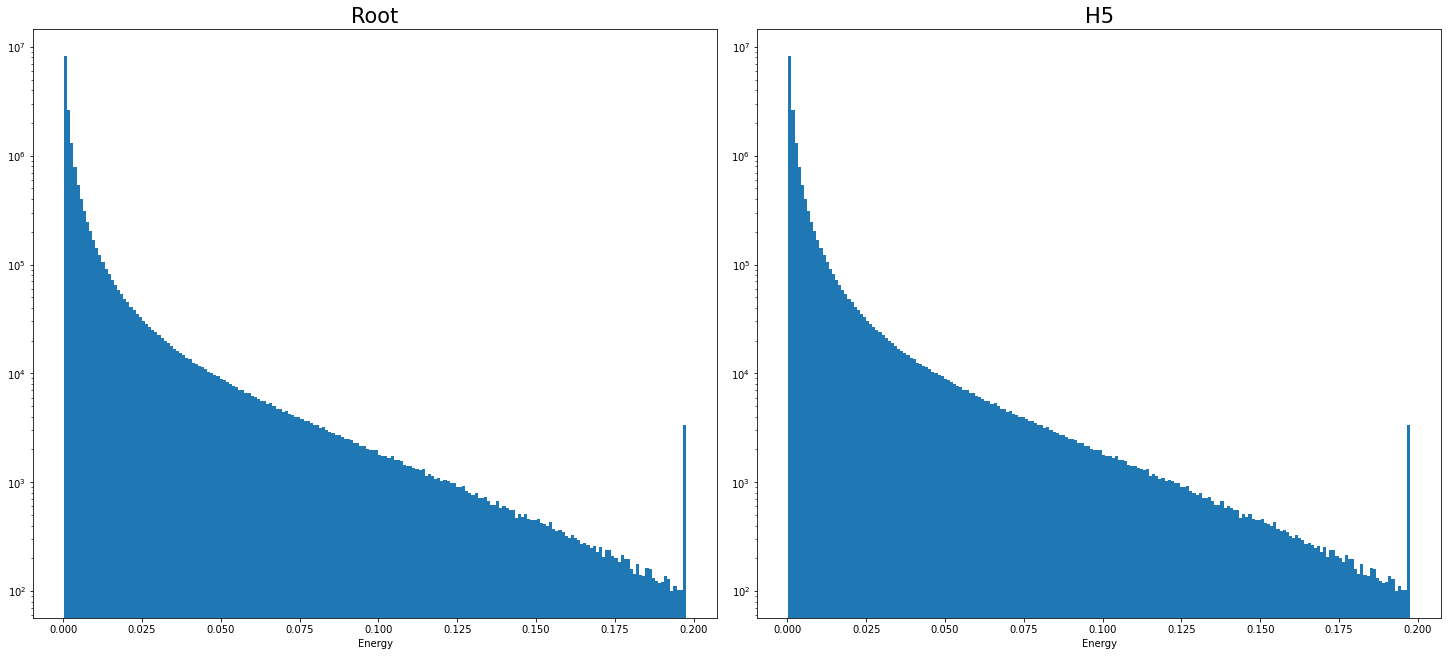

  array length:  200


 Number of differences:  0




In [11]:
make_comparison_plots( root_hits_e, h5_hits_e, 'Energy' )

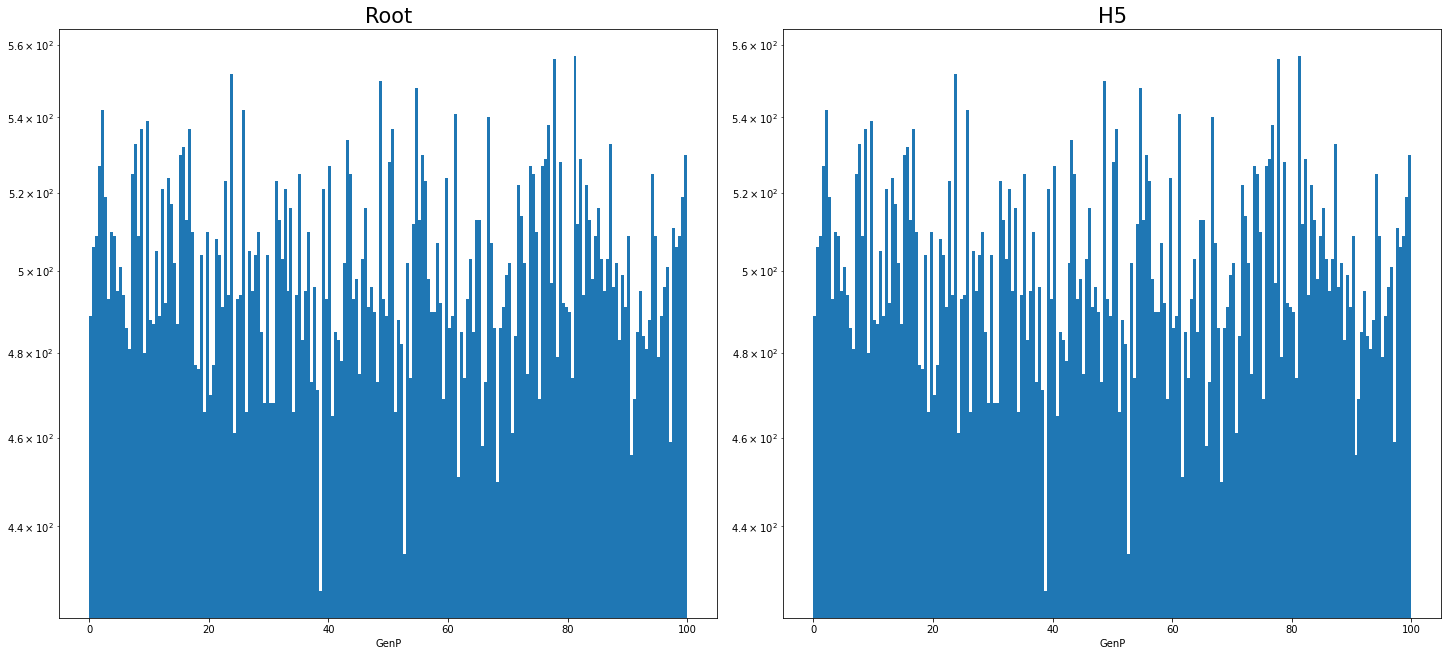

  array length:  200


 Number of differences:  0




In [12]:
make_comparison_plots( root_gen_P, h5_gen_P, 'GenP' )

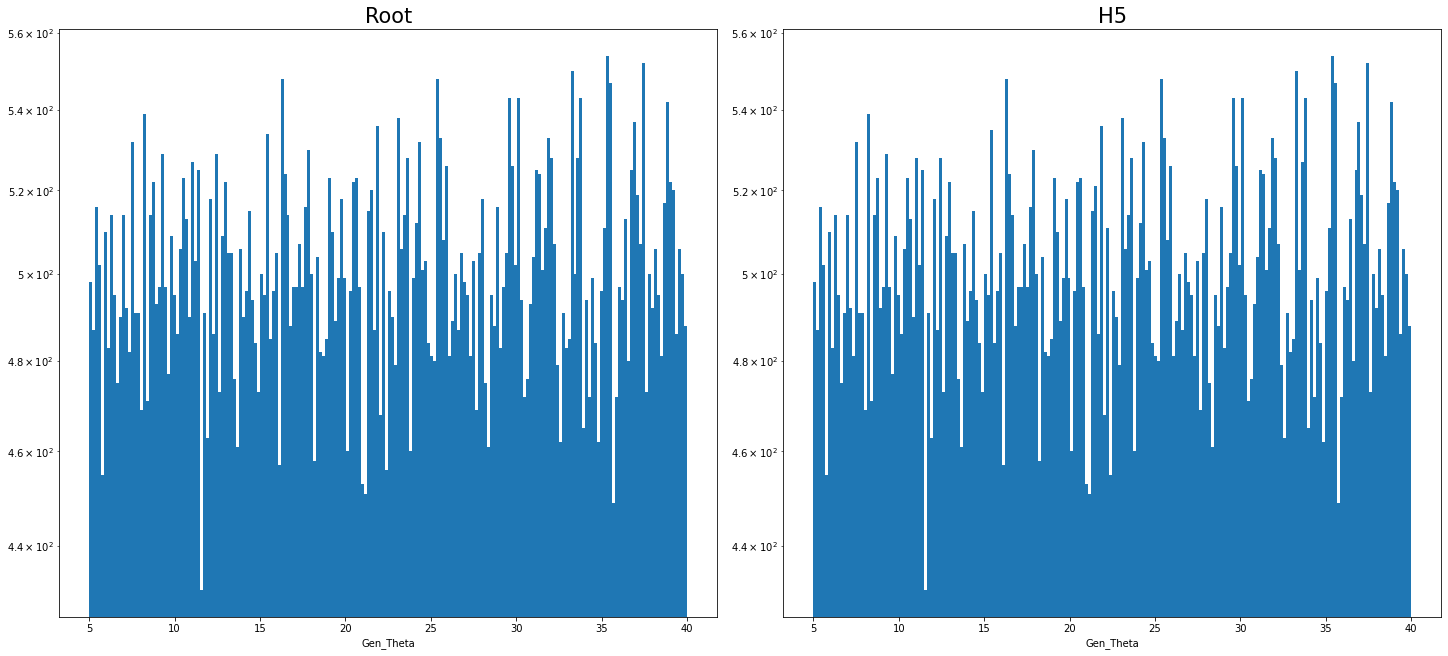

  array length:  200
  10  :        490        491  Rectangle(xy=(6.75054, 0), width=0.174996, height=490, angle=0) *** -1
  13  :        482        481  Rectangle(xy=(7.27553, 0), width=0.174996, height=482, angle=0) *** 1
  21  :        522        523  Rectangle(xy=(8.6755, 0), width=0.174996, height=522, angle=0) *** -1
  22  :        493        492  Rectangle(xy=(8.8505, 0), width=0.174996, height=493, angle=0) *** 1
  34  :        527        528  Rectangle(xy=(10.9505, 0), width=0.174996, height=527, angle=0) *** -1
  35  :        503        502  Rectangle(xy=(11.1255, 0), width=0.174996, height=503, angle=0) *** 1
  41  :        486        487  Rectangle(xy=(12.1754, 0), width=0.174997, height=486, angle=0) *** -1
  42  :        529        528  Rectangle(xy=(12.3504, 0), width=0.174996, height=529, angle=0) *** 1
  50  :        506        507  Rectangle(xy=(13.7504, 0), width=0.174996, height=506, angle=0) *** -1
  51  :        490        489  Rectangle(xy=(13.9254, 0), width=0.1

In [13]:
make_comparison_plots( root_gen_Theta, h5_gen_Theta, 'Gen_Theta' )

In [14]:
print(root_gen_Theta[:6])
print(h5_gen_Theta[:6])

[36.945995  10.734123  23.766855  25.62213   29.375656   7.7012024]
[36.945995 10.734142 23.766855 25.62213  29.375673  7.701203]


# Cluster Sum

In [15]:
root_cluster_sum = ak.sum(root_hits_e,axis=-1)
root_cluster_sum = ak.to_numpy(root_cluster_sum)

In [16]:
hdf5_cluster_sum = np.nansum(h5_hits_e,axis=-1)

In [17]:
print(len(root_cluster_sum))

100000


# Cut on Clusters (Where the Trouble Begins)

In [18]:
cluster_mask = root_cluster_sum > min_cluster_E
if (cut_on_genP):
    cluster_mask = np.logical_and(cluster_mask, root_gen_P > 20.)
if (cut_on_clusters):
    root_cluster_sum = root_cluster_sum[cluster_mask]
    hdf5_cluster_sum = hdf5_cluster_sum[cluster_mask]
    root_gen_P = root_gen_P[cluster_mask]
    root_gen_Theta = root_gen_Theta[cluster_mask]
    h5_gen_P = h5_gen_P[cluster_mask]
    h5_gen_Theta = h5_gen_Theta[cluster_mask]

In [19]:
theta_mask = root_gen_Theta > min_theta
theta_mask = np.logical_and(root_gen_Theta < max_theta,theta_mask)

if (cut_on_genTheta):
    root_cluster_sum = root_cluster_sum[theta_mask]
    hdf5_cluster_sum = hdf5_cluster_sum[theta_mask]
    root_gen_P = root_gen_P[theta_mask]
    root_gen_Theta = root_gen_Theta[theta_mask]
    h5_gen_P = h5_gen_P[theta_mask]
    h5_gen_Theta = h5_gen_Theta[theta_mask]

#### Compare clusters with and withOUT cuts (depricated)

## Cluster Sum and Truth P Correlation

Text(0.5, 1.0, '[HDF5] HCal Sum vs. Generated Energy')

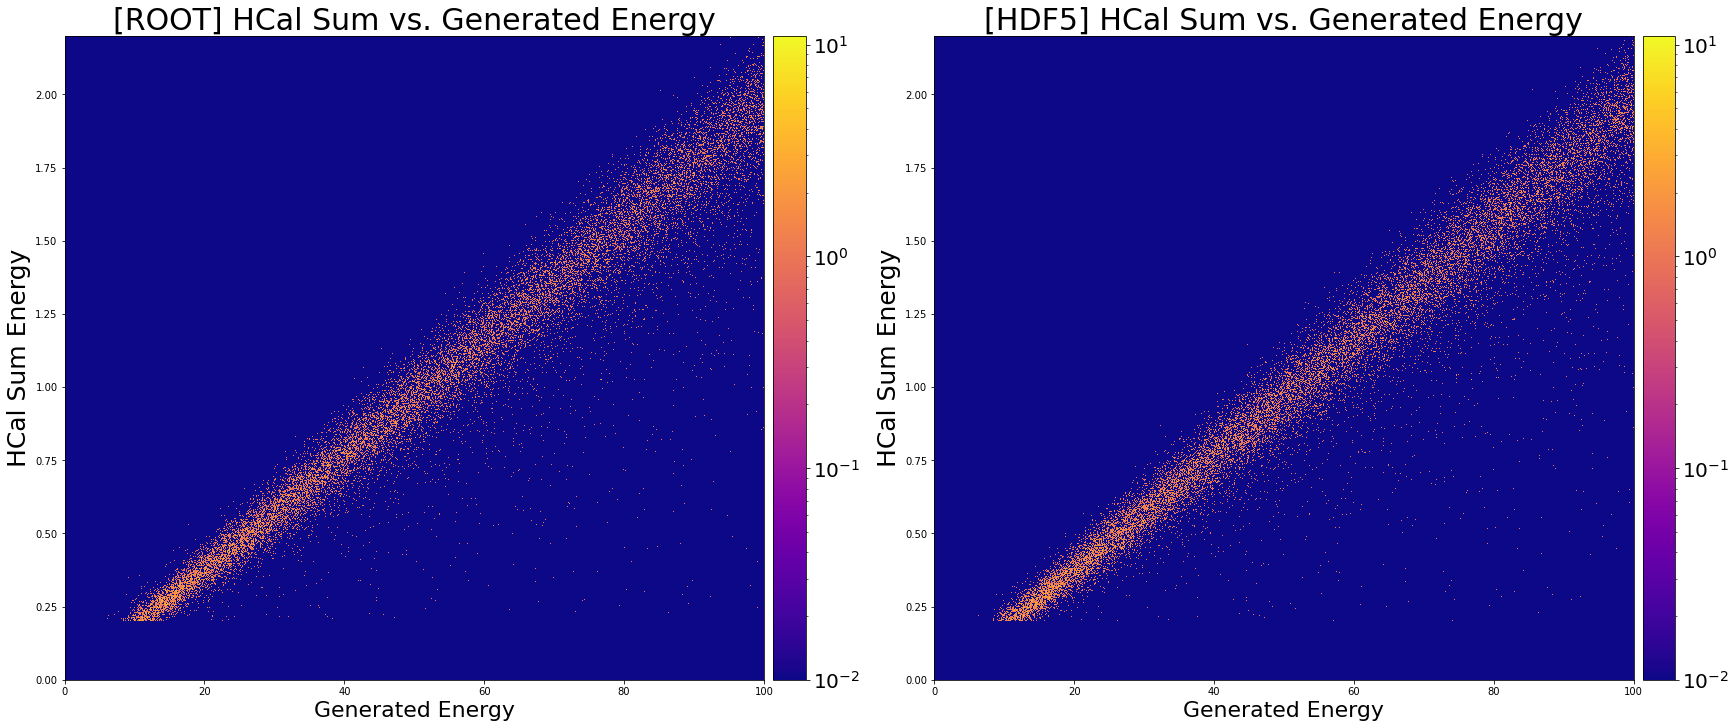

In [20]:
from copy import copy
from matplotlib.colors import LogNorm
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10), constrained_layout=True)
axes = axes.ravel()
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))

cluster_edges=np.linspace(0,2.200,1201)
truth_edges=np.linspace(0,100,1201)


#ROOT
h, xedges, yedges = np.histogram2d(root_gen_P, root_cluster_sum, bins=[truth_edges, cluster_edges])
pcm = axes[0].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=1.1e1), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[0], pad=0)
cb.ax.tick_params(labelsize=20)
axes[0].set_xlabel("Generated Energy",fontsize=22)
axes[0].set_ylabel("HCal Sum Energy",fontsize=25)
axes[0].set_title("[ROOT] HCal Sum vs. Generated Energy",fontsize=30)


#HDF5
h, xedges, yedges = np.histogram2d(h5_gen_P, hdf5_cluster_sum, bins=[truth_edges, cluster_edges])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=1.1e1), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[1], pad=0)
cb.ax.tick_params(labelsize=20)
axes[1].set_xlabel("Generated Energy",fontsize=22)
axes[1].set_ylabel("HCal Sum Energy",fontsize=25)
axes[1].set_title("[HDF5] HCal Sum vs. Generated Energy",fontsize=30)

# At this point, it should be established that ROOT and HDF5 data is IDENTICAL

## Last check: Train on HDF5 and ROOT

In [21]:
h5_X = hdf5_cluster_sum
h5_Y = h5_gen_P

R_X = root_cluster_sum
R_Y = root_gen_P

In [22]:
(h5_X_train, h5_X_val, h5_X_test,
h5_Y_train, h5_Y_val, h5_Y_test) = data_split(h5_X, h5_Y, val=0.2, test=0.3,shuffle=shuffle_split)

(R_X_train, R_X_val, R_X_test,
R_Y_train, R_Y_val, R_Y_test) = data_split(R_X, R_Y, val=0.2, test=0.3,shuffle=shuffle_split)

In [23]:
def step_decay(epoch, lr):
    min_rate = 1.01e-7
    N_start = 40
    N_epochs = 20
    
    return lr
    
    if epoch >= N_start and lr >= min_rate:
        if (epoch%N_epochs==0):
            return lr * 0.1
    return lr

lr_decay = tf.keras.callbacks.LearningRateScheduler(step_decay,verbose=0)

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience)

In [25]:
#from tensorflow.keras.layers import Input
h5_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[1]),
    tf.keras.layers.Dense(32, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(32, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(1,activation="linear") # output layer
])

h5_model.compile(loss=loss, optimizer="adam")

h5_fit = h5_model.fit(h5_X_train, h5_Y_train, epochs=100,
                    validation_data=(h5_X_val,h5_Y_val),
                    callbacks=[lr_decay,early_stopping],
                    batch_size=batch_size)


R_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[1]),
    tf.keras.layers.Dense(32, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(32, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(1,activation="linear") # output layer
])

R_model.compile(loss=loss, optimizer="adam")

R_fit = R_model.fit(R_X_train, R_Y_train, epochs=100,
                    validation_data=(R_X_val,R_Y_val),
                    callbacks=[lr_decay,early_stopping],
                    batch_size=batch_size)


Epoch 1/100


2022-12-01 15:53:25.563821: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/global/home/users/ftoralesacosta/user_pkg/usr/lib:/global/home/users/ftoralesacosta/user_pkg/usr/lib64:/lib:/lib64:/usr/lib:/usr/lib64
2022-12-01 15:53:25.563845: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-12-01 15:53:25.564977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions

32/32 [==============================] - 0s 5ms/step - loss: 55.1937 - val_loss: 54.8717 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 54.3421 - val_loss: 53.9009 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 53.1207 - val_loss: 52.3082 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 51.0560 - val_loss: 49.6344 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 47.6728 - val_loss: 45.3572 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 42.4337 - val_loss: 38.9505 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 34.8490 - val_loss: 30.0481 - lr: 0.0010
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 25.1214 - val_loss: 19.7789 - lr: 0.0010
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 15.4529 - val_loss: 11.3697

In [26]:
h5_model.save("%s/h5_energy_regression.h5"%(path))
h5_preds = h5_model.predict(h5_X_test,batch_size=400)    
np.save("%s/h5_predictions.npy"%(path),h5_preds)
np.save("%s/h5_y_test.npy"%(path),h5_Y_test)
np.save("%s/h5_x_test.npy"%(path),h5_X_test)

R_model.save("%s/R_energy_regression.h5"%(path))
R_preds = R_model.predict(R_X_test,batch_size=400)    
np.save("%s/R_predictions.npy"%(path),R_preds)
np.save("%s/R_y_test.npy"%(path),R_Y_test)
np.save("%s/R_x_test.npy"%(path),R_X_test)

47/47 [==============================] - 0s 576us/step


___

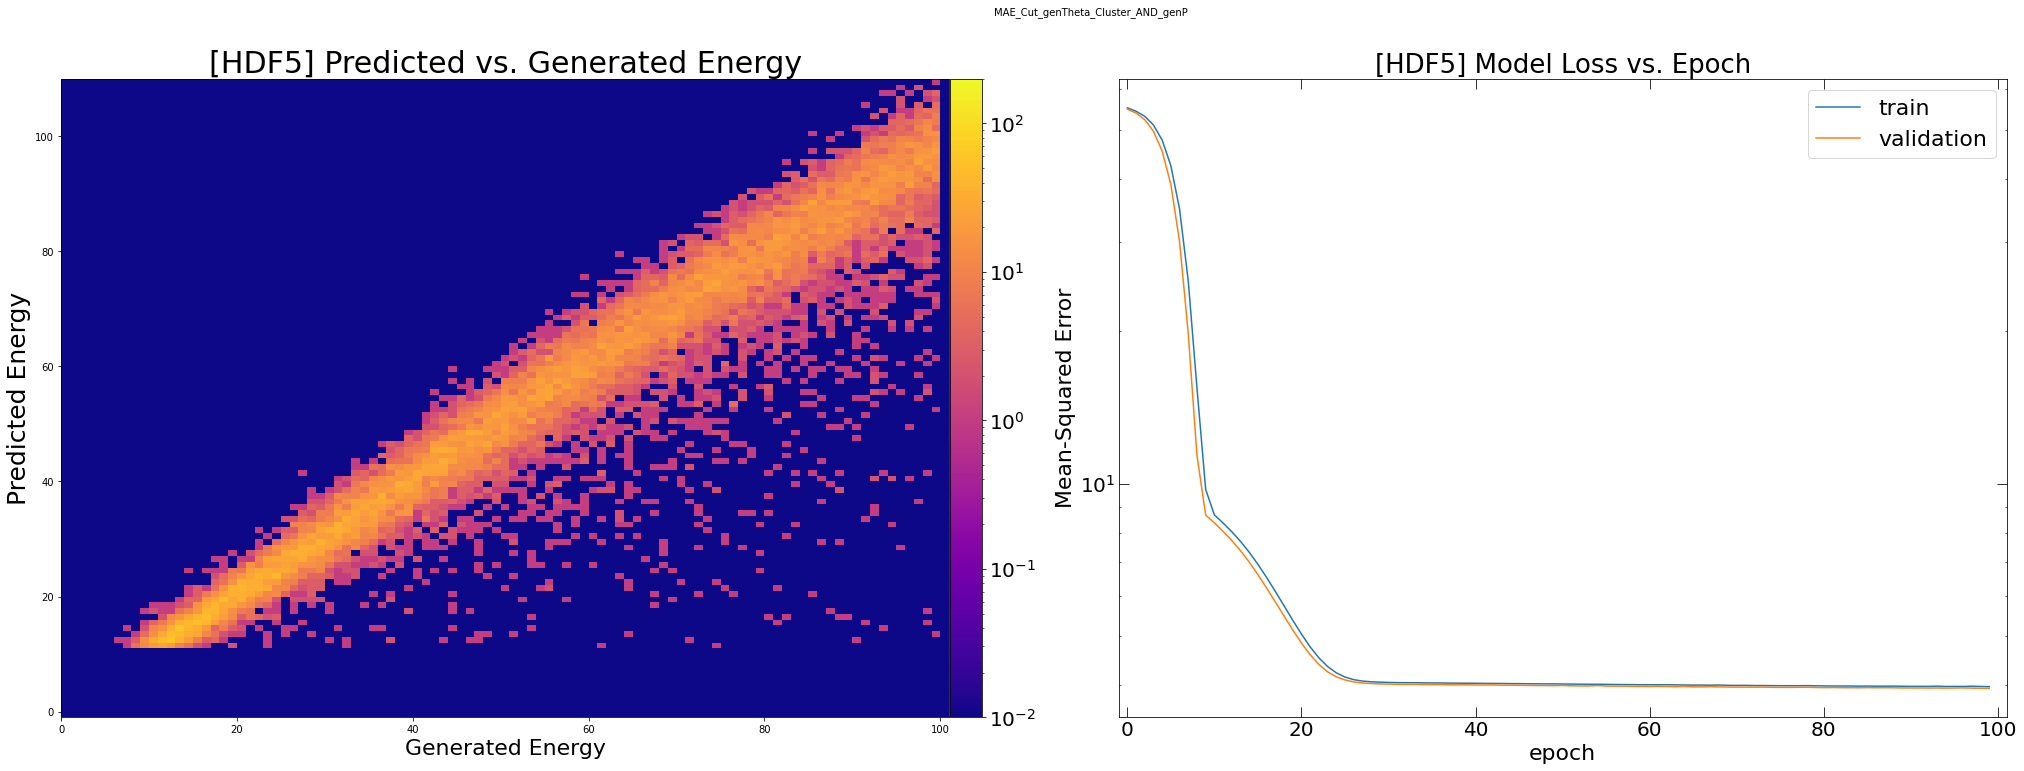

In [27]:
fig, axes = plt.subplots(1, 2,figsize=(28,10),constrained_layout=True)
#fig,axs = plt.subplots(int(N/10),10, figsize=(32, 16),sharex=False,sharey=True,constrained_layout=True)
axes = axes.ravel()
from copy import copy
from matplotlib.colors import LogNorm
#fig, axes = plt.subplots(nrows=1, figsize=(14, 10), constrained_layout=True)
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
edges=np.linspace(-10,110,121)
h, xedges, yedges = np.histogram2d(h5_Y_test,h5_preds[:,0], bins=[edges, edges])
#xedges=yedges
pcm = axes[0].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=2.0e2), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[0], pad=0)
#cb.set_label("Counts",fontsize=22)
cb.ax.tick_params(labelsize=20)
axes[0].set_xlabel("Generated Energy",fontsize=22)
#axes[0].set_yticks(fontsize=20)
#axes[0].set_xticks(fontsize=20)
axes[0].set_ylim(-1,110)
axes[0].set_xlim(-0,101)
axes[0].set_ylabel("Predicted Energy",fontsize=25)
axes[0].set_title("[HDF5] Predicted vs. Generated Energy",fontsize=30)


axes[1].plot(h5_fit.history['loss'])
axes[1].plot(h5_fit.history['val_loss'])
axes[1].set_title('[HDF5] Model Loss vs. Epoch',fontsize=26)

fig.text(1.05,1.1,label,transform=axes[0].transAxes,fontsize=10)
axes[1].set_ylabel('Mean-Squared Error',fontsize=22)
axes[1].set_yscale('log')
axes[1].set_xlabel('epoch',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.tick_params(direction='in',right=True,top=True,which='minor')
axes[1].set_xlim([-1,101])
axes[1].legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.savefig("%s/H5_Correlation.png"%(path))

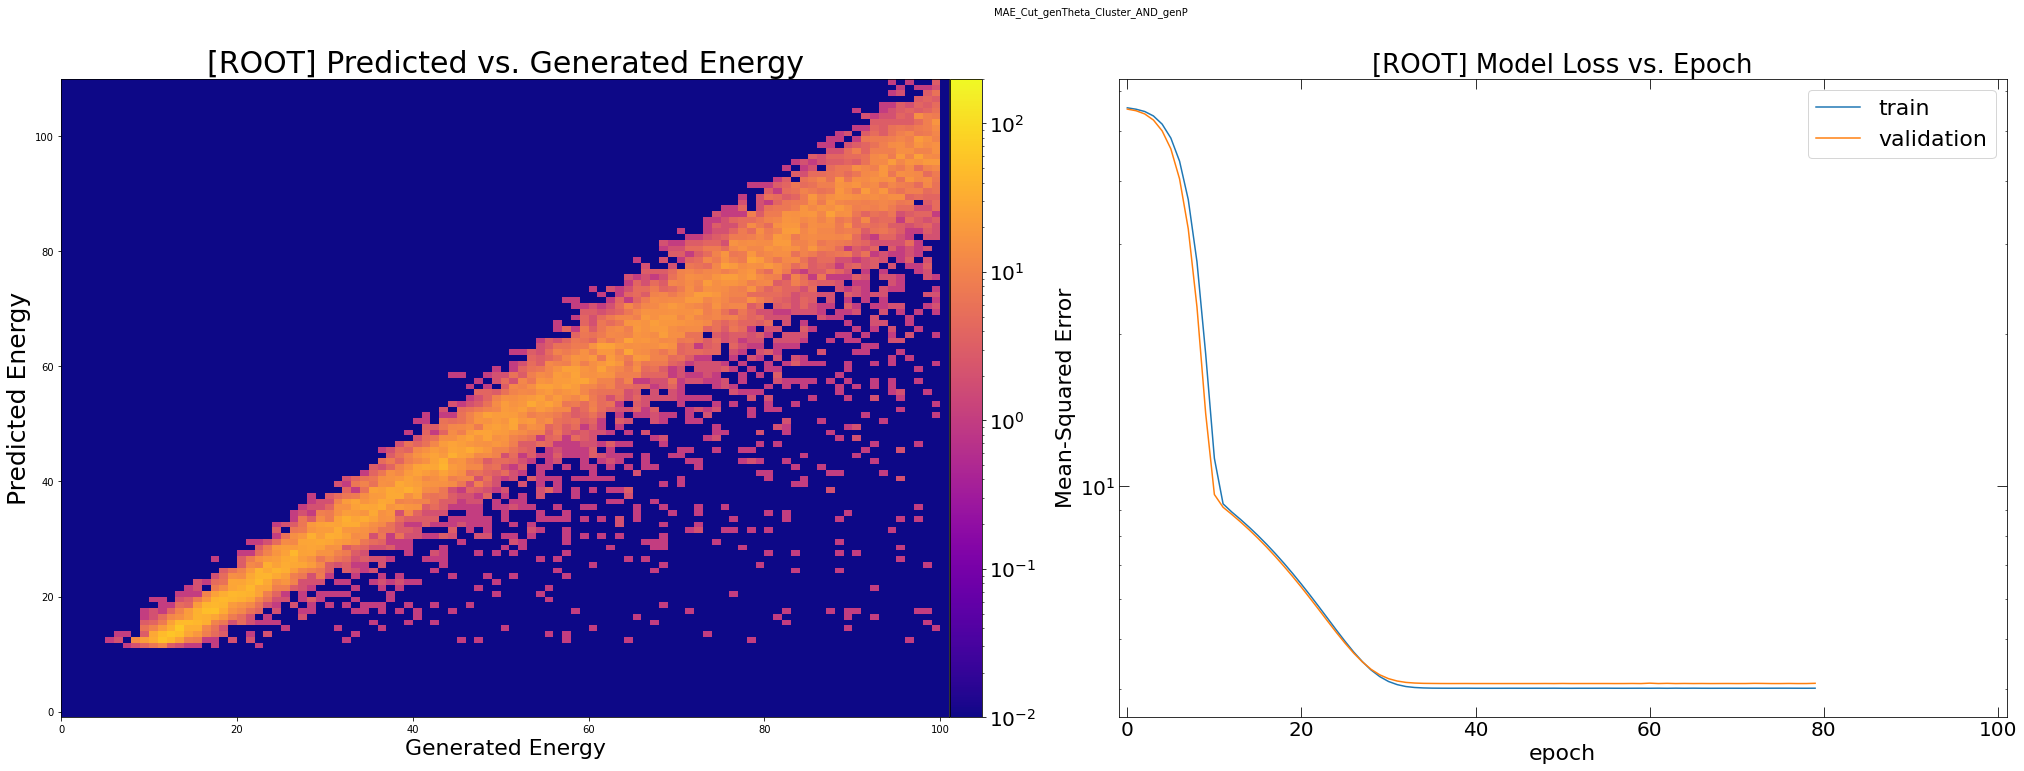

In [28]:
fig, axes = plt.subplots(1, 2,figsize=(28,10),constrained_layout=True)
axes = axes.ravel()
from copy import copy
from matplotlib.colors import LogNorm
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
edges=np.linspace(-10,110,121)
h, xedges, yedges = np.histogram2d(R_Y_test,R_preds[:,0], bins=[edges, edges])
pcm = axes[0].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmin=1.0e-2,vmax=2.0e2), rasterized=True)
cb = fig.colorbar(pcm, ax=axes[0], pad=0)
cb.ax.tick_params(labelsize=20)
axes[0].set_xlabel("Generated Energy",fontsize=22)
axes[0].set_ylim(-1,110)
axes[0].set_xlim(-0,101)
axes[0].set_ylabel("Predicted Energy",fontsize=25)
axes[0].set_title("[ROOT] Predicted vs. Generated Energy",fontsize=30)


axes[1].plot(R_fit.history['loss'])
axes[1].plot(R_fit.history['val_loss'])
axes[1].set_title('[ROOT] Model Loss vs. Epoch',fontsize=26)

fig.text(1.05,1.1,label,transform=axes[0].transAxes,fontsize=10)
axes[1].set_ylabel('Mean-Squared Error',fontsize=22)
axes[1].set_yscale('log')
axes[1].set_xlabel('epoch',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.tick_params(direction='in',right=True,top=True,which='minor')
axes[1].set_xlim([-1,101])
axes[1].legend(['train', 'validation'], loc='upper right',fontsize=22)
plt.savefig("%s/ROOT_Correlation.png"%(path))

In [29]:
star_energies = [12,16,20,25,30,50,60,70]
star_res = [0.18, 0.16, 0.15, 0.14, 0.13, 0.098, 0.092, 0.090]

ECCE_res = [0.15,0.127,0.117,0.121,0.106,0.102,0.092,0.098]
ECCE_energies = [10,20,30,40,50,60,80,100]

In [30]:
from data_functions import get_res_scale

In [31]:
N_Bins = 20
E_Bins = np.linspace(0,100,N_Bins+1)

h5_resolution, h5_pred_over_truth, h5_avg_truth,h5_slices = get_res_scale(h5_Y_test,h5_preds)
h5_strawman_res, h5_strawman_scale, h5_avg_truth, h5_strawman_slices = get_res_scale(h5_Y_test,h5_X_test)

R_resolution, R_pred_over_truth, R_avg_truth,R_slices = get_res_scale(R_Y_test,R_preds)
R_strawman_res, R_strawman_scale, R_avg_truth,R_strawman_slices = get_res_scale(R_Y_test,R_X_test)

/clusterfs/ml4hep_nvme2/ftoralesacosta/regressiononly/data_functions.py:73: RuntimeWarning: invalid value encountered in true_divide
  avg_truth = avg_truth/counter
/global/home/users/ftoralesacosta/anaconda3/envs/tin/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/clusterfs/ml4hep_nvme2/ftoralesacosta/regressiononly/data_functions.py:78: RuntimeWarning: invalid value encountered in true_divide
  scale = test_over_truth/counter


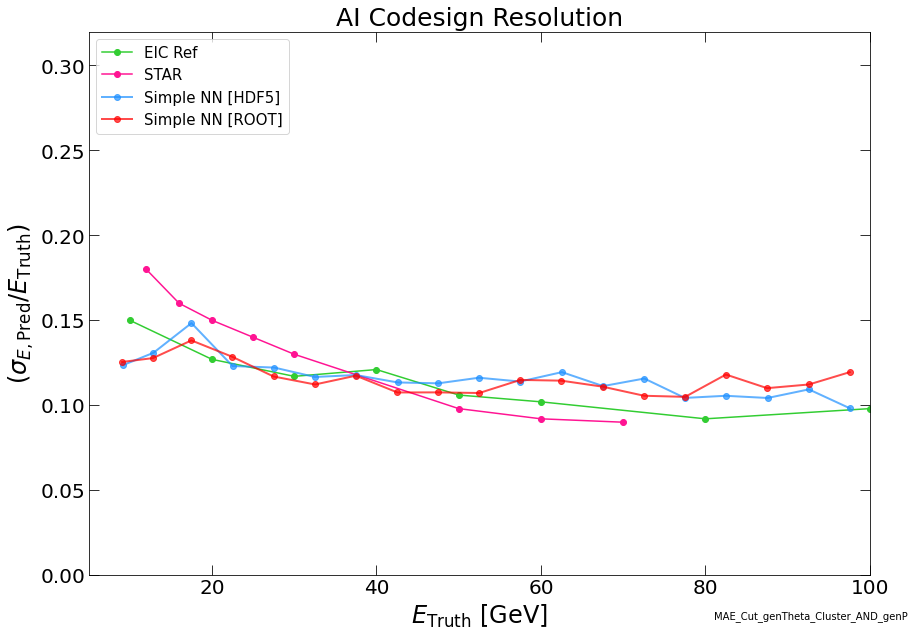

In [32]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Resolution",fontsize=25)
plt.ylabel("$(\sigma_{E,\mathrm{Pred}}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
#plt.ylim(-0.02,0.4)
plt.ylim(0,2)
plt.ylim(0,.32)
plt.xlim(-0.01,100.01)
plt.xlim(5.0,100)
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = 20

plt.text(0.8,-0.08,label,transform=ax.transAxes,fontsize=10)
plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_resolution[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",color='dodgerblue',alpha=0.7,label="Simple NN [HDF5]")

plt.errorbar(R_avg_truth[first_bin:last_bin],R_resolution[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',marker="o",color='red',alpha=0.7,label="Simple NN [ROOT]")

plt.plot(ECCE_energies,ECCE_res,"-o",label = "EIC Ref",color="limegreen")
plt.plot(star_energies,star_res,"-o",label = "STAR",color="deeppink")
plt.legend(fontsize=15,loc="upper left")
plt.savefig("%s/h5_resolution_plot.pdf"%(path))




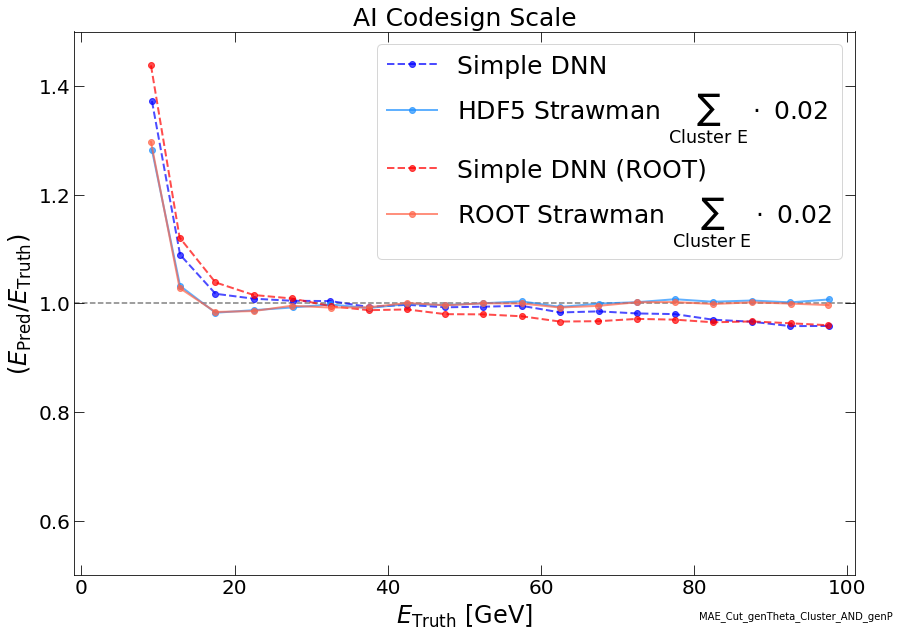

In [33]:
fig=plt.figure(figsize=(14,10))
plt.title("AI Codesign Scale",fontsize=25)
plt.ylabel("$(E_\mathrm{Pred}/E_\mathrm{Truth})$",fontsize=24)
plt.xlabel("$E_\mathrm{Truth}$ [GeV]",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(direction='in',right=True,top=True,length=10)
plt.axhline(y=1.0, color='k', linestyle='--',alpha=0.5)#plt.ylim(-0.02,0.4)
plt.ylim(0.5,1.5)
plt.xlim(-1,101)
#errors = 1.0/(np.sqrt(2*counter-2))*stdev_pred
ax = plt.subplot(1,1,1)
first_bin = 0
last_bin = N_Bins

string = "HDF5"
color1 = 'blue'
color2 = 'dodgerblue'
#HDF5 NN   
plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",color=color1,alpha=0.7,label="Simple DNN")

#Strawman
scale = h5_strawman_scale[int(len(h5_strawman_scale)/2)] #Scale to mid point, what NN should learn
plt.errorbar(h5_avg_truth[first_bin:last_bin],h5_strawman_scale[first_bin:last_bin]/scale,
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',
             marker="o",color=color2,alpha=0.7,label="HDF5 Strawman $\sum_\mathrm{Cluster\ E}\cdot\ %1.2f$"%(scale))


#ROOT NN
plt.errorbar(R_avg_truth[first_bin:last_bin],R_pred_over_truth[first_bin:last_bin],#yerr=errors[first_bin:last_bin],
             linestyle="--",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,
             ecolor='black',marker="o",color='red',alpha=0.7,label="Simple DNN (ROOT)")

#ROOT Strawman
root_scale = R_strawman_scale[int(len(R_strawman_scale)/2)] #Scale to mid point, what NN should learn
plt.errorbar(R_avg_truth[first_bin:last_bin],R_strawman_scale[first_bin:last_bin]/root_scale,
             linestyle="-",linewidth=2.0,capsize=4,capthick=1.2,elinewidth=1.2,ecolor='black',
             marker="o",color='tomato',alpha=0.7,label="ROOT Strawman $\sum_\mathrm{Cluster\ E}\cdot\ $%1.2f"%(root_scale))

#plt.text(0.7,0.7,"ROOT",transform=ax.transAxes,fontsize=25)

plt.legend(fontsize=25)
plt.text(0.8,-0.08,label,transform=ax.transAxes,fontsize=10)


plt.savefig("%s/%s_scale_plot.pdf"%(path,string))

/tmp/ipykernel_22458/453906475.py:16: RuntimeWarning: Mean of empty slice
  ax.axvline(x=np.nanmean(h5_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))


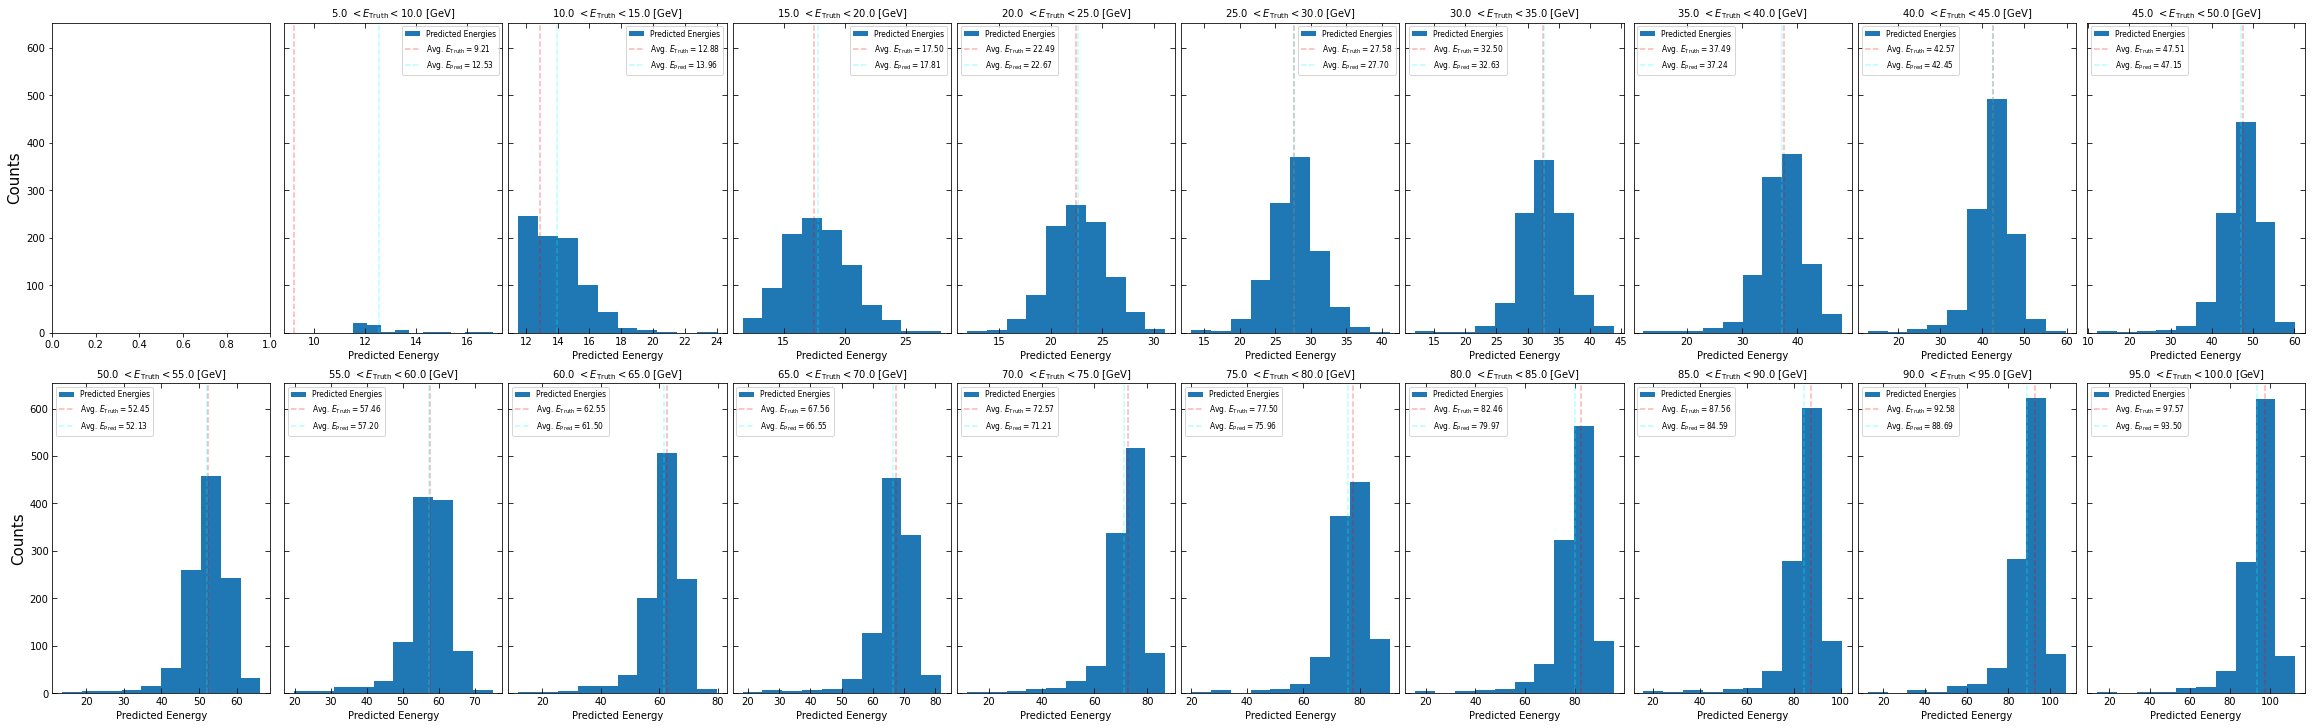

In [34]:
fig,axs = plt.subplots(int(N_Bins/10),10, figsize=(32, 10),sharex=False,sharey=True,constrained_layout=True)
for i in range(N_Bins):
    row = int(i/10)
    col = i%10
    if(row==int(N_Bins/10)): continue
    ax = axs[row,col]
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)
    if (np.all(np.isnan(h5_slices[i]))): continue
    temp_bin = np.linspace(h5_avg_truth[i]-2.0,h5_avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]),fontsize=10)
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(h5_slices[i],label="Predicted Energies")
    ax.axvline(x=h5_avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(h5_avg_truth[i]))
    ax.axvline(x=np.nanmean(h5_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))

    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("%s/h5_resolutions_slices.pdf"%(path))

/tmp/ipykernel_22458/637129509.py:17: RuntimeWarning: Mean of empty slice
  ax.axvline(x=np.nanmean(R_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))


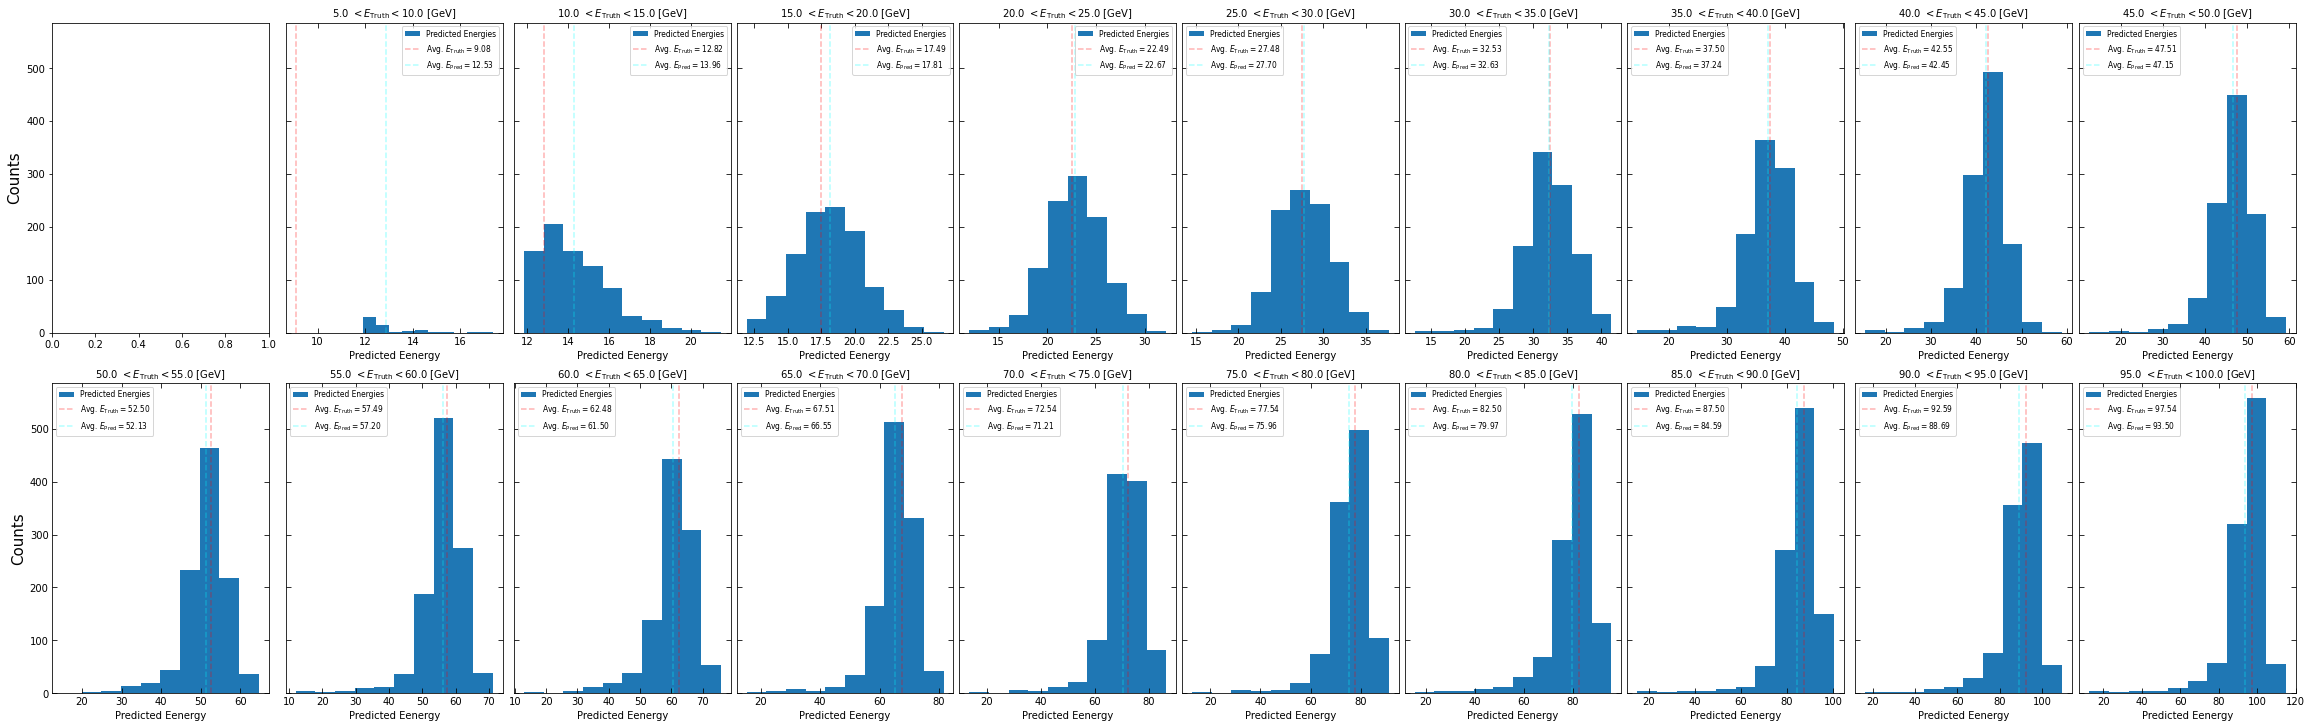

In [35]:
fig,axs = plt.subplots(int(N_Bins/10),10, figsize=(32, 10),sharex=False,sharey=True,constrained_layout=True)
for i in range(N_Bins):
    row = int(i/10)
    col = i%10
    if(row==int(N_Bins/10)): continue
    ax = axs[row,col]
    
    if (col==0):
        ax.set_ylabel("Counts",fontsize=15)

    if (np.all(np.isnan(R_slices[i]))): continue
    temp_bin = np.linspace(R_avg_truth[i]-2.0,R_avg_truth[i]+2.0,16)
    ax.set_title("%1.1f $ < E_\mathrm{Truth} < $%1.1f [GeV]"%(E_Bins[i],E_Bins[i+1]),fontsize=10)
    ax.set_xlabel("Predicted Eenergy")
    ax.hist(R_slices[i],label="Predicted Energies")
    ax.axvline(x=R_avg_truth[i],color='red',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Truth} = %1.2f$"%(R_avg_truth[i]))
    ax.axvline(x=np.nanmean(R_slices,axis=-1)[i],color='cyan',alpha=0.3,linestyle="--",label="Avg. $E_\mathrm{Pred} = %1.2f$"%(np.nanmean(h5_slices,axis=-1)[i]))

    ax.legend(fontsize=7.5)
    ax.tick_params(direction='in',right=True,top=True,length=5)
plt.savefig("%s/R_resolutions_slices.pdf"%(path))

If Normalization is desired